Information Gain = E(Parent)-weighted average of E(Children)
E = -summation(p*log(p))
p = probability of a class

Stopping Criteria : Maximum Depth, Minimum number of samples before you divide, minimum impurity decrease

TO BE CARED


In [33]:
import numpy as np

In [34]:
# testing bincount and argmax function
arrayy = np.array([1, 2, 5, 4, 5, 5, 7, 8, 8])
print(np.bincount(arrayy))
print(np.argmax(np.bincount(arrayy)))

[0 1 1 0 1 3 0 1 2]
5


In [35]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        # * used for leaf node creation
        self.feature = feature  # feature for separation
        self.threshold = threshold  # separation threshold
        self.left = left
        self.right = right  # left and right pointers
        self.value = value  # only for leaf nodes

    def is_leaf(self):
        return self.value is not None


In [36]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split #minimum number of samples in order to split a node since we dont want data to overfit at any cost
        self.max_depth = max_depth # maximum depth tree can take
        self.n_features = n_features  # number of features that need to considered
        self.root = None
    
    def about(self):
        print("Decision Tree Classifier")
        print("min_samples_split: ", self.min_samples_split)
        print("max_depth: ", self.max_depth)
        print("n_features: ", self.n_features)
    
    def most_common_label(self, y):
        return (np.argmax(np.bincount(y)))
        
    def fit(self, X, y):
        if(self.n_features == None):
            self.n_features = X.shape[1]
        else:
            if(self.n_features > X.shape[1]):
                raise ValueError("n_features cannot be greater than total number of features")
                    # Make sure the number of features is less than or equal to the available features
        self.root = self._grow_tree(X, y)

    def _best_split(self, X, y, feat_index):
        best_gain = -1
        split_index, split_threshold = None, None
        for feat_idx in feat_index:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_index = feat_idx
                    split_threshold = threshold
        return split_threshold, split_index
    
    def _grow_tree(self, X, y, depth=0):
        n_samples= X.shape[0]
        n_features = X.shape[1]
        n_labels = len(np.unique(y))
        # Check stopping criteria
        if ((depth >= self.max_depth) or (n_labels == 1) or( n_samples < self.min_samples_split)):
            # return new node simple
            leaf_value = self.most_common_label(y)
            return Node(value=leaf_value)

        # Find best split
        feat_index = np.random.choice(n_features, self.n_features, replace=False)
        best_threshold, best_feature = self._best_split(X, y, feat_index)

        # Create child nodes
        left_idxs,right_idxs = self._split(X[:, best_feature], best_threshold)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs , :], y[right_idxs ], depth+1)

        return Node(best_feature,best_threshold,left,right)


        # Call grow tree on child nodes
    
    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)
        left_idx, right_idx = self._split(X_column, threshold)
        if len(left_idx) == 0 or len(right_idx) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idx), len(right_idx)
        e_l, e_r = self._entropy(y[left_idx]), self._entropy(y[right_idx])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        ig = parent_entropy - child_entropy
        return ig
            
    def _split(self, X_column, threshold):
        left_idx = np.argwhere(X_column <= threshold).flatten()
        right_idx = np.argwhere(X_column > threshold).flatten()
        return left_idx, right_idx

    
    def _entropy(self, y):
        # Calculate and return entropy
        # example if array is [1,2,3,1,2] 
        hist = np.bincount(y)
        ps = hist / len(y)
        # you got the probabilities
        return -np.sum([p * np.log2(p) for p in ps if p > 0])
    
    def predict(self,X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if(node.is_leaf()):
            return node.value
        
        if(x[node.feature] <= node.threshold):
            return self._traverse_tree(x, node.left)
        
        return self._traverse_tree(x, node.right)


     


In [38]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder


data=pd.read_csv('Q1Data.csv')
selected_features = ['MFCCs_ 1', 'MFCCs_ 2', 'MFCCs_ 3', 'MFCCs_ 4', 'MFCCs_ 5', 'MFCCs_ 6']
X = data[selected_features]
Y= data['Genus']
le = LabelEncoder()
Y = le.fit_transform(Y)
clf = DecisionTree(max_depth=8)
X = X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.80, random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, predictions)
print(acc)
print(clf.about())

0.8860319666435025
Decision Tree Classifier
min_samples_split:  2
max_depth:  8
n_features:  6
None


In [40]:
import matplotlib.pyplot as plt
max_depths = range(1, 16)
test_accuracies = []

for depth in max_depths:
    clf = DecisionTree(max_depth=depth)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    acc = accuracy(y_test, predictions)
    test_accuracies.append(acc)



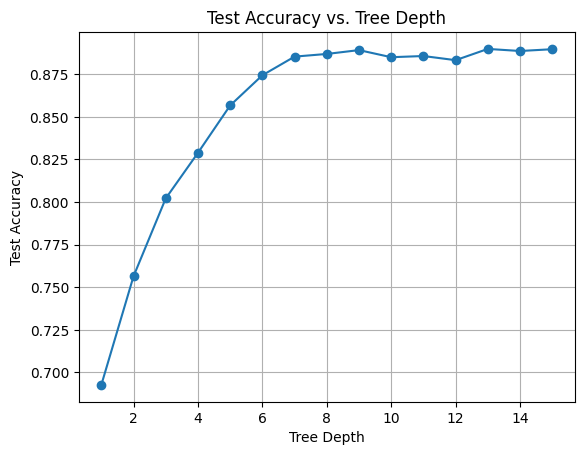

In [41]:
# Plot the results
plt.plot(max_depths, test_accuracies, marker='o')
plt.title('Test Accuracy vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

The graph indicates a positive correlation between the depth of the Decision Tree and its accuracy on the test set. As the depth increases, accuracy improves, reaching a peak around a depth of 10. Beyond this point, accuracy plateaus or slightly declines, suggesting diminishing returns and potential overfitting to the training data.

Interpretation:

Initial Improvement: Deeper trees capture intricate patterns, enhancing performance on the training set.

Diminishing Returns: Accuracy plateaus after a depth of 10, signifying limited gains and a risk of overfitting.